## Project Vehicle Detection

### First include needed modules

In [216]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label


### Read vehicle and non-vehicle images for training

In [35]:
# Readup the car and noncars images using cv2.imread() so they are loaded with a space 0 to 255
# The video pipeline uses the same scale so we don't have to rescale there
cars = []
notcars = []

images = glob.glob('./vehicles/*/*.png')
for file in images:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)

images = glob.glob('./non-vehicles/*/*.png')
for file in images:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcars.append(image)
    
n_vehicles = len(cars)
n_non_vehicles = len(notcars)

print("Vehicle images: %i" % n_vehicles)
print("Non vehicle images: %i" % n_non_vehicles)

Vehicle images: 8792
Non vehicle images: 8968


Image shape: (64, 64, 3) Data type: uint8


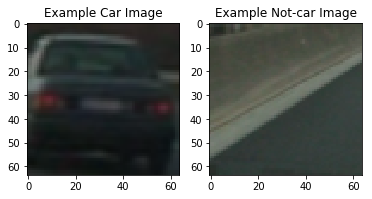

In [41]:
# Print Sample images
car_ind = np.random.randint(0, n_vehicles)
notcar_ind = np.random.randint(0, n_non_vehicles)
    
# Read in car / not-car images
car_image = cars[car_ind]
notcar_image = notcars[notcar_ind]

print('Image shape:', car_image.shape,'Data type:', car_image.dtype)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

### Define functions for features extraction

In [217]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(image, color_space='RGB'):
        if color_space != 'RGB':
            if color_space == 'HSV':
                return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: return np.copy(image)      

# Define a function to extract features from a single image window
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):         
    img_features = []
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, color_space)

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features)
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        img_features = single_img_features(image, color_space, spatial_size,
                                          hist_bins, orient,
                                          pix_per_cell, cell_per_block, hog_channel,
                                          spatial_feat, hist_feat, hog_feat)
        features.append(img_features)
    # Return list of feature vectors
    return features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def find_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    # Return the bboxes
    return bboxes

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Set Parameters

In [158]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

### Display hog features

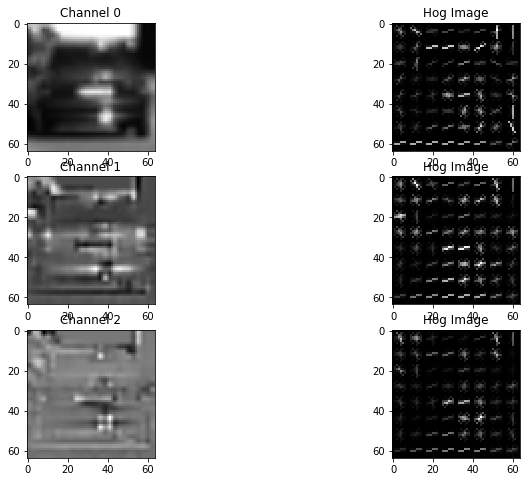

In [159]:
# Display hog features on a random car image
car_ind = np.random.randint(0, n_vehicles)
    
# Read in car images
image = cars[car_ind]
feature_image = convert_color(image, color_space)

# Plot the examples
fig = plt.figure()
channels = feature_image.shape[2]
for channel in range(channels):
    test_feature, hog_image = get_hog_features(feature_image[:,:,channel], 
                        orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
    pos = channel * 2
    plt.subplot(channels, 2,pos + 1)
    plt.imshow(feature_image[:,:,channel], cmap='gray')
    plt.title('Channel %d' % channel)
    plt.subplot(channels, 2, pos + 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('Hog Image')

Size = fig.get_size_inches()
fig.set_size_inches(Size[0]*2, Size[1]*2, forward=True)    
plt.show()

### Extract features

In [160]:
# Extract features for all images
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

129.13 Seconds to extract features...


### Train LinearSVC

In [161]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',color_space,'colorspace',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: YUV colorspace 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
40.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


In [162]:
# Check the prediction time for a single sample of 10
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.02799 Seconds to predict 10 labels with SVC


### Define functions for sliding windows 

In [163]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Load all test images to work with

In [164]:
test_images = {}
for file in glob.glob('./test_images/*.jpg'):
    img = mpimg.imread(file)
    test_images[file.split('/')[-1]] = img

### Show visualization of searching patterns

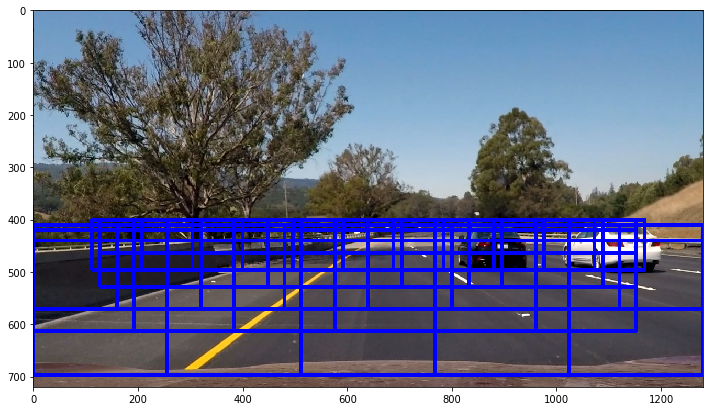

In [197]:
test_image = test_images['test6.jpg']

# define a list with search paterns
# [x_start_stop, y_start_stop, scale]
search_pattern = [
    [[128, 1152], [400, 528], 1],
    [[112, 1168], [400, 400 + 96], 1.5],
    ##[[None, None], [405, 405 + 128], 2],
    [[None, None], [410, 410 + 160], 2.5],
    [[None, None], [420, None], 3],
    ##[[None, None], [430, None], 3.5],
    [[None, None], [440, None], 4],
    
]
window_img = np.copy(test_image)

for pattern in search_pattern:
    x_start_stop = pattern[0]
    y_start_stop = pattern[1]
    scale = pattern[2]
    xy_window=(int(64 * scale), int(64 * scale))
    xy_overlap=(0., 0.)
    windows = slide_window(window_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=6)                    

fig = plt.figure()
Size = fig.get_size_inches()
fig.set_size_inches(Size[0]*2, Size[1]*2, forward=True)    
plt.imshow(window_img)
plt.show()

### Define function for searching cars

In [166]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [200]:
windows = []
for pattern in search_pattern:
    x_start_stop = pattern[0]
    y_start_stop = pattern[1]
    scale = pattern[2]
    xy_window=(int(64 * scale), int(64 * scale))
    xy_overlap=(0.5, 0.5)
    windows += slide_window(out_img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)
        
for file_name in test_images.keys():
    image = test_images[file_name]
    out_img = np.copy(image)
    t=time.time()
    hot_windows = search_windows(out_img, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
    out_img = draw_boxes(out_img, hot_windows, color=(0, 0, 255), thick=6)  
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to process image', file_name)
    plt.imsave('output_images/' + file_name, out_img)

1.23 Seconds to process image test6.jpg
1.13 Seconds to process image test3.jpg
1.11 Seconds to process image test4.jpg
1.17 Seconds to process image test1.jpg
1.34 Seconds to process image test5.jpg
1.15 Seconds to process image test2.jpg


In [212]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, 
              x_start_stop=[None, None], y_start_stop=[None, None], scale=1, 
              color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32):

    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    ystart = y_start_stop[0]
    ystop = y_start_stop[1]

    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return on_boxes

In [213]:
#Run on test_images
for file_name in test_images.keys():
    image = test_images[file_name]
    out_img = np.copy(image)
    t = time.time()
    #for pattern in search_pattern:
    #    x_start_stop = pattern[0]
    #    y_start_stop = pattern[1]
    #    scale = pattern[2]
    y_start_stop = [400, 656]
    scale = 1.5
    hot_windows = find_cars(out_img, svc, X_scaler, 
                            x_start_stop, y_start_stop, scale,
                            color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img = draw_boxes(out_img, hot_windows, color=(0, 0, 255), thick=6)  
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to process image', file_name)
    plt.imsave('output_images/' + file_name, out_img)

0.55 Seconds to process image test6.jpg
0.49 Seconds to process image test3.jpg
0.4 Seconds to process image test4.jpg
0.46 Seconds to process image test1.jpg
0.48 Seconds to process image test5.jpg
0.4 Seconds to process image test2.jpg


In [137]:
# Prepare working directories
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [222]:
ensure_dir('videos_output/')

buffer_windows = []

def process_image(image):
#    for pattern in search_pattern:
#        x_start_stop = pattern[0]
#        y_start_stop = pattern[1]
#        scale = pattern[2]
    y_start_stop = [400, 656]
    scale = 1.5

    hot_windows = find_cars(image, svc, X_scaler, 
                            x_start_stop, y_start_stop, scale,
                            color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)    
#    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                    spatial_size=spatial_size, hist_bins=hist_bins, 
#                    orient=orient, pix_per_cell=pix_per_cell, 
#                    cell_per_block=cell_per_block, 
#                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                    hist_feat=hist_feat, hog_feat=hog_feat)
    # Add finds to buffer
    buffer_windows.append(hot_windows)
    # Keep only the last 5
    if (len(buffer_windows) > 5):
        buffer_windows.pop(0)
        
    # Filter outliers
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, np.concatenate(buffer_windows))
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bboxes = find_labeled_bboxes(image, labels)
    image = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)  
    return image

video_output = 'videos_output/test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(process_image) 
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video videos_output/test_video.mp4
[MoviePy] Writing video videos_output/test_video.mp4


 97%|█████████▋| 38/39 [00:18<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/test_video.mp4 

CPU times: user 17.5 s, sys: 531 ms, total: 18.1 s
Wall time: 20.5 s


In [223]:
# Clear buffer
buffer_windows = []

video_output = 'videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) 
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video videos_output/project_video.mp4
[MoviePy] Writing video videos_output/project_video.mp4


 11%|█         | 135/1261 [01:04<08:55,  2.10it/s]

ValueError: all the input arrays must have same number of dimensions